****
# Import modules
****

In [1]:
import os
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf

****
# Load Data
****

In [2]:
file_path = "C:\\Users\\kruu\\store\\data_LSGG\\"

data_LSGG = pd.read_parquet(os.path.join(file_path + "landing_df_LSGG_with_meteo_0_of_22.parquet"))

for i in range(1, 22):
    temp = pd.read_parquet(os.path.join(file_path + f"landing_df_LSGG_with_meteo_{i}_of_22.parquet"))
    data_LSGG = pd.concat((data_LSGG, temp))
    

In [3]:
data_LSGG[["avg_wind_dir", "avg_wind_speed", "avg_vis", "avg_temp", "avg_press"]].isna().any()

avg_wind_dir       True
avg_wind_speed    False
avg_vis           False
avg_temp          False
avg_press         False
dtype: bool

In [4]:
data_LSGG["nominal_distance_prop"] = data_LSGG["distance"] / data_LSGG["nominal_distance"] 

In [5]:
# STAR selection for the model
selected_stars = ["BELU3N", "KINE2N", "AKIT3R", "LUSA2N"]
lr_data = data_LSGG.query(f"star in {selected_stars}")

In [6]:
# Redefinition of rush hours according to: https://www.slotcoordination.ch/public/upload/assets/875/gvas24sos.pdf?fp=1
# 7 - 10 / 11 -13 / 14 - 17 / 20 - 21

import pytz

def is_rush_hour(date):
    
    # Extract hour everything in UTC
    hour = date.hour
    minute = date.minute
    time_in_minutes = hour * 60 + minute
    
    if (7 * 60 <= time_in_minutes <= 10 * 60) or \
       (11 * 60 <= time_in_minutes <= 13 * 60) or \
       (14 * 60 <= time_in_minutes <= 17 * 60) or \
       (20 * 60 <= time_in_minutes <= 21 * 60):
        return True
    else:
        return False

lr_data['rush_hour'] = lr_data["start"].apply(is_rush_hour)


C:\Users\kruu\AppData\Local\Temp\ipykernel_60036\3044179275.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_data['rush_hour'] = lr_data["start"].apply(is_rush_hour)


In [7]:
# aircraft sizes

ac_body = {
    "Widebody": ["B763", "A333"],
    "Narrowbody": ["A320", "BCS3", "A20N", "A319", "BCS1", "A21N", "B738", "A321"],
    "Regional Jet": ["E190", "CRJ9", "E195", "DH8D"],
    "Business jets": ["PC12", "C56X", "F2TH", "PC24", "C68A", "E55P"],
}

def body_type(typecode, ac_body_dict):
    for key, value in ac_body_dict.items():
        if typecode in value:
            return key
    return None

lr_data[["body_type"]] =  lr_data.typecode.apply(lambda x: pd.Series(body_type(x, ac_body)))

C:\Users\kruu\AppData\Local\Temp\ipykernel_60036\3853508159.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_data[["body_type"]] =  lr_data.typecode.apply(lambda x: pd.Series(body_type(x, ac_body)))


****
# LR Model
****

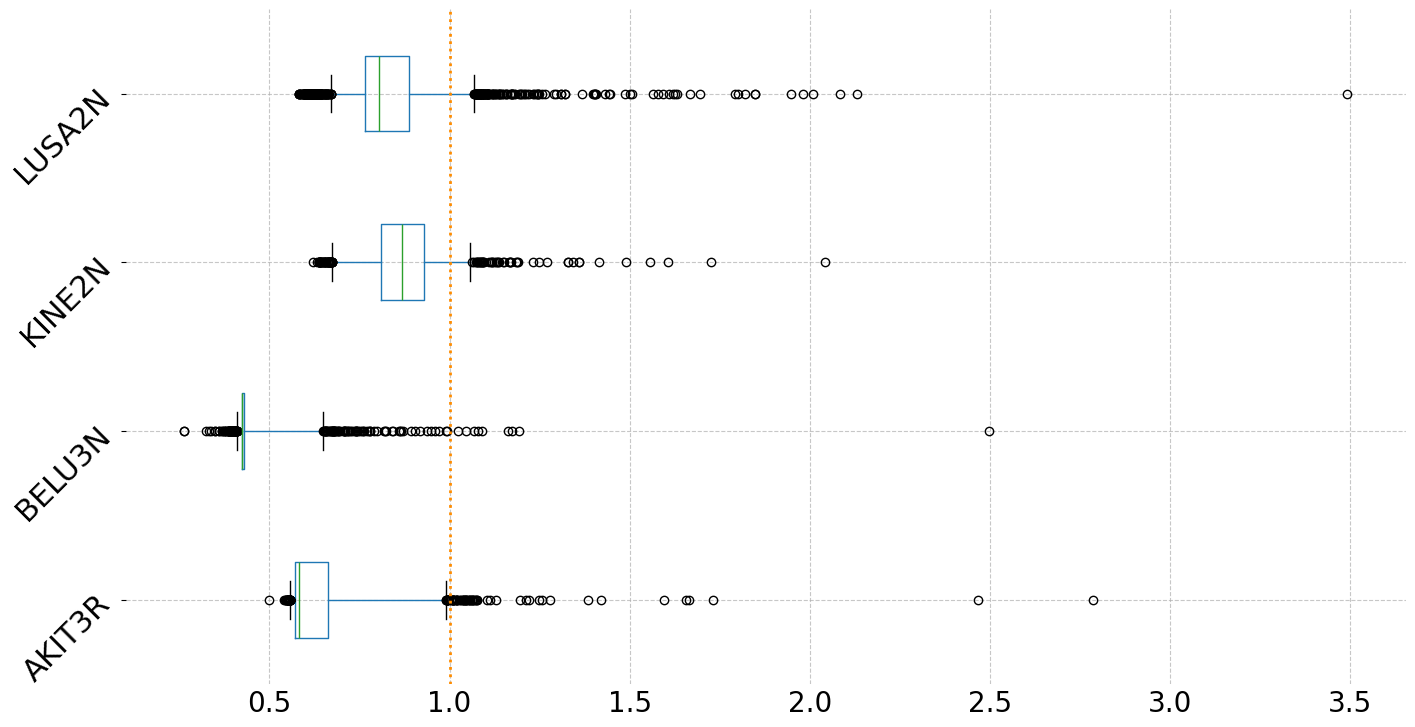

In [8]:
boxplot = lr_data.boxplot(["nominal_distance_prop"], by = ["star"],
                     figsize = (16, 9),
                     vert = False,
                     showmeans = False,
                     notch = False,
                     whis = (2.5,97.5))

boxplot.axvline(x=1, color='darkorange', linestyle=':', linewidth=2)

custom_labels = ['AKIT3R', 'BELU3N', 'KINE2N', 'LUSA2N']
boxplot.set_yticklabels(custom_labels, fontsize=22, rotation=45)

boxplot.get_figure().suptitle('')
boxplot.set_ylabel("")
boxplot.set_title('')

boxplot.set_axisbelow(True)
boxplot.grid(True, linestyle='--', alpha=0.7)
boxplot.spines['top'].set_visible(False)
boxplot.spines['right'].set_visible(False)
boxplot.spines['left'].set_visible(False)
boxplot.spines['bottom'].set_visible(False)
boxplot.tick_params(axis='x', which='both', length=0, labelsize=20)

- If one were to model the categorical star variable as a fixed effect that model would assume the group means (one from each star) are independent from each other and shere the residul variance.
- if the categorical star variable is modeled as a random effect (random intercept only) the model would assume that the star measured are a sample of a larger population of stars that has its own mean and variance 

Not completely sure about modelling with LMM. The random effect intercept (for instance), gives us a confidence interval for the intercepts of all stars. 

Example: we have here a variance for the intercept of 0.019 i.e. an std of 0.14. It means that at 95%, the intercept of each star is located in 0.865 +/- 3*0.14. 

Do we really need that ? We can just model the STAR as categorical variables and make the assumption (maybe a bit strong but anyway) that the observatiosn are independent among the different stars (the covariates affect the distance proportion equally for all stars)

In [9]:
model_lm = smf.ols(
    "nominal_distance_prop ~ C(star) + C(weekday) + avg_vis + avg_wind_speed + C(season) + avg_vis + avg_press + C(body_type, Treatment(reference='Narrowbody')) + C(rush_hour) + avg_temp", 
    lr_data, 
)

res_lm = model_lm.fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     nominal_distance_prop   R-squared:                       0.707
Model:                               OLS   Adj. R-squared:                  0.707
Method:                    Least Squares   F-statistic:                     1652.
Date:                   Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                           17:03:15   Log-Likelihood:                 10822.
No. Observations:                  13706   AIC:                        -2.160e+04
Df Residuals:                      13685   BIC:                        -2.144e+04
Df Model:                             20                                         
Covariance Type:               nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.7237      0.012     62.158      0.000       0.701       0.746
C(star)[T.BELU3N]                                                   -0.1962      0.003    -62.246      0.000      -0.202      -0.190
C(star)[T.KINE2N]                                                    0.2309      0.004     64.134      0.000       0.224       0.238
C(star)[T.LUSA2N]                                                    0.1870      0.003     63.317      0.000       0.181       0.193
C(weekday)[T.1]                                                     -0.0170      0.004     -4.741      0.000      -0.024      -0.010
C(weekday)[T.2]                                                     -0.0110      0.004     -3.084      0.002      -0.018      -0.004
C(weekday)[T.3]                                                     -0.0106      0.004     -2.823      0.005      -0.018      -0.003
C(weekday)[T.4]                                                      0.0026      0.003      0.742      0.458      -0.004       0.009
C(weekday)[T.5]                                                      0.0048      0.003      1.391      0.164      -0.002       0.012
C(weekday)[T.6]                                                      0.0209      0.003      6.365      0.000       0.014       0.027
C(season)[T.Spring]                                                 -0.0038      0.003     -1.207      0.227      -0.010       0.002
C(season)[T.Summer]                                                 -0.0016      0.004     -0.401      0.689      -0.010       0.006
C(season)[T.Winter]                                                  0.0079      0.003      2.506      0.012       0.002       0.014
C(body_type, Treatment(reference='Narrowbody'))[T.Business jets]     0.0070      0.003      2.157      0.031       0.001       0.013
C(body_type, Treatment(reference='Narrowbody'))[T.Regional Jet]      0.0004      0.005      0.091      0.927      -0.009       0.010
C(body_type, Treatment(reference='Narrowbody'))[T.Widebody]          0.0163      0.006      2.926      0.003       0.005       0.027
C(rush_hour)[T.True]                                                 0.0234      0.002     12.255      0.000       0.020       0.027
avg_vis                                                             -0.0130      0.001    -10.980      0.000      -0.015      -0.011
avg_wind_speed                                                       0.0046      0.000     16.956      0.000       0.004       0.005
avg_press                                                            0.0003      0.000      2.341      0.019    5.52e-05    

In [ ]:
print(res_lm.summary().as_latex())

C:\Users\kruu\AppData\Local\Temp\ipykernel_60036\3442349273.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalue = significance_stars(p_values[indices][i])
C:\Users\kruu\AppData\Local\Temp\ipykernel_60036\3442349273.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if p_values[indices][i] < 0.05:
C:\Users\kruu\AppData\Local\Temp\ipykernel_60036\3442349273.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if p_values[ind

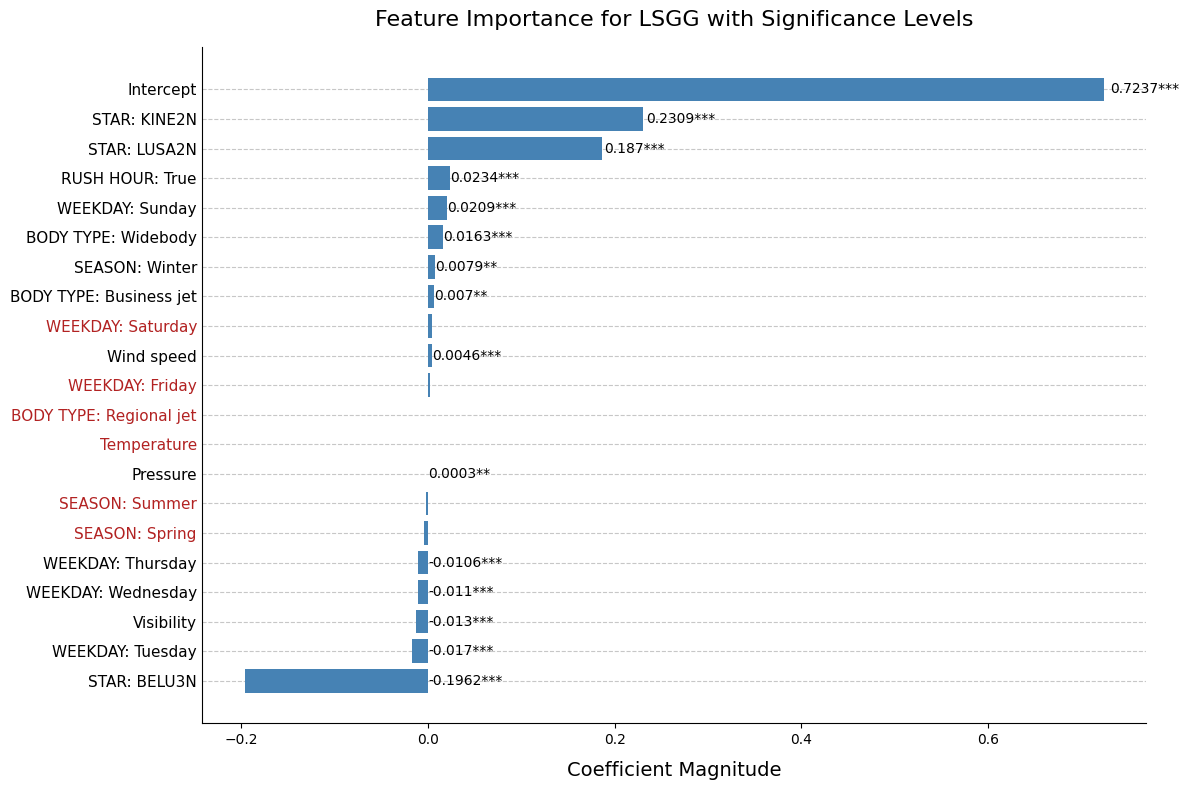

In [12]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = res_lm.params
p_values = res_lm.pvalues

# features = coefficients.index  # Feature names
features = np.array([ #Same order as coefficients.index 
    "Intercept", 
    "STAR: BELU3N",
    "STAR: KINE2N",
    "STAR: LUSA2N",
    "WEEKDAY: Tuesday",
    "WEEKDAY: Wednesday",
    "WEEKDAY: Thursday",
    "WEEKDAY: Friday",
    "WEEKDAY: Saturday",
    "WEEKDAY: Sunday",
    "SEASON: Spring",
    "SEASON: Summer",
    "SEASON: Winter",
    "BODY TYPE: Business jet",
    "BODY TYPE: Regional jet",
    "BODY TYPE: Widebody",
    "RUSH HOUR: True",
    "Visibility",
    "Wind speed",
    "Pressure",
    "Temperature",
])
importance = coefficients.values  # Absolute coefficients to represent feature importance

indices = np.argsort(importance)

bar_color = 'steelblue'

def significance_stars(p_value):
    if p_value <= 0.01:
        return '***'
    elif p_value <= 0.05:
        return '**'
    elif p_value <= 0.10:
        return '*'
    else:
        return ''

plt.figure(figsize=(12, 8))
plt.barh(range(len(importance)), importance[indices], align='center', color=bar_color)

for i in range(len(importance)):
    pvalue = significance_stars(p_values[indices][i])
    if p_values[indices][i] < 0.05: 
        if importance[indices][i] > 0:
            plt.text(importance[indices][i] * 1.01, i, f'{np.round(importance[indices][i],4)}{pvalue}', va='center', fontsize=10)
        else:
            plt.text(0.001, i, f'{np.round(importance[indices][i],4)}{pvalue}', va='center', fontsize=10)
        

y_labels = plt.yticks(range(len(importance)), features[indices], fontsize=11)
for i in range(len(importance)):
    if p_values[indices][i] > 0.05:
        y_labels[1][i].set_color('firebrick')

ax = plt.gca()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.tick_params(axis='y', which='both', length=0)

plt.xlabel('Coefficient Magnitude', fontsize=14, labelpad=10)
plt.title('Feature Importance for LSGG with Significance Levels', fontsize=16, pad=15)
plt.tight_layout()
plt.show()


****
# Linear mixed model
****

In [45]:
# The effect of these predictors is assumed to be constant across all observations.
fixed_effect = "nominal_distance_prop ~ C(body_type, Treatment(reference='Narrowbody')) + C(weekday) + avg_vis + avg_wind_speed + avg_press + rush_hour" 

# Randome effect at STAR level
random_effect = "~ avg_vis + avg_wind_speed + C(weekday)"

model_mixed = smf.mixedlm(
    fixed_effect, 
    lr_data,
    groups = "star", 
    re_formula=random_effect
)

res_mixedlm = model_mixed.fit()
res_mixedlm.summary()

c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                          MixedLM              Dependent Variable:              nominal_distance_prop
No. Observations:               13706                Method:                          REML                 
No. Groups:                     4                    Scale:                           0.0121               
Min. group size:                1867                 Log-Likelihood:                  10729.4065           
Max. group size:                5807                 Converged:                       Yes                  
Mean group size:                3426.5                                                                     
-----------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                         0.784    0.204  3.847 0.000  0.384  1.183
C(body_type, Treatment(reference='Narrowbody'))[T.Business jets]  0.009    0.003  2.760 0.006  0.003  0.015
C(body_type, Treatment(reference='Narrowbody'))[T.Regional Jet]  -0.001    0.005 -0.259 0.796 -0.010  0.008
C(body_type, Treatment(reference='Narrowbody'))[T.Widebody]       0.013    0.006  2.339 0.019  0.002  0.024
C(weekday)[T.1]                                                  -0.018    0.013 -1.434 0.151 -0.044  0.007
C(weekday)[T.2]                                                  -0.011    0.009 -1.160 0.246 -0.030  0.008
C(weekday)[T.3]                                                  -0.009    0.009 -0.993 0.321 -0.025  0.008
C(weekday)[T.4]                                                   0.004    0.006  0.747 0.455 -0.007  0.015
C(weekday)[T.5]                                                   0.004    0.007  0.571 0.568 -0.010  0.019
C(weekday)[T.6]                                                   0.019    0.009  2.053 0.040  0.001  0.037
rush_hour[T.True]                                                -0.000    0.002 -0.234 0.815 -0.004  0.003
avg_vis                                                          -0.011    0.006 -1.884 0.060 -0.023  0.000
avg_wind_speed                                                    0.004    0.007  0.603 0.547 -0.010  0.018
avg_press                                                         0.000    0.000  3.278 0.001  0.000  0.001
star Var                                                          0.165                                    
star x C(weekday)[T.1] Cov                                       -0.010                                    
C(weekday)[T.1] Var                                               0.001                                    
star x C(weekday)[T.2] Cov                                       -0.007                                    
C(weekday)[T.1] x C(weekday)[T.2] Cov                             0.000                                    
C(weekday)[T.2] Var                                               0.000                                    
star x C(weekday)[T.3] Cov                                       -0.005                                    
C(weekday)[T.1] x C(weekday)[T.3] Cov                             0.000                                    
C(weekday)[T.2] x C(weekday)[T.3] Cov                             0.000                                    
C(weekday)[T.3] Var                                               0.000                                    
star x C(weekday)[T.4] Cov                                       -0.001                                    
C(weekday)[T.1] x C(weekday)[T.4] Cov                             0.000                           

Random intercept model:
- Variance accross stars = 0.209 (std = sqrt(0.209) = 0.457). This is the variation of the intercept accross stars. On average, the proportion vary about 45 % accross the stars under investigation. I guess here it's a bit meaningless as we don't consider that the 4 stars are among a bigger pool of stars. What we want is the exact variations from one star to another, which is given by the regular linear regression. 
- There is no mixed effect for the avg_vis and the avg_wind speed, meaning that those factors are only fixed effect. It is nice to mention. Basically, it means that across the 4 stars under investigation, 

C:\Users\kruu\AppData\Local\Temp\ipykernel_12188\3562775136.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res_lm.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm, ax = ax1)
c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
c:\Users\kruu\git_folder\STAR_shortcut_OSN_paper\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWa

Statistic 0.7679703216904845
p-value 3.193787703996003e-87


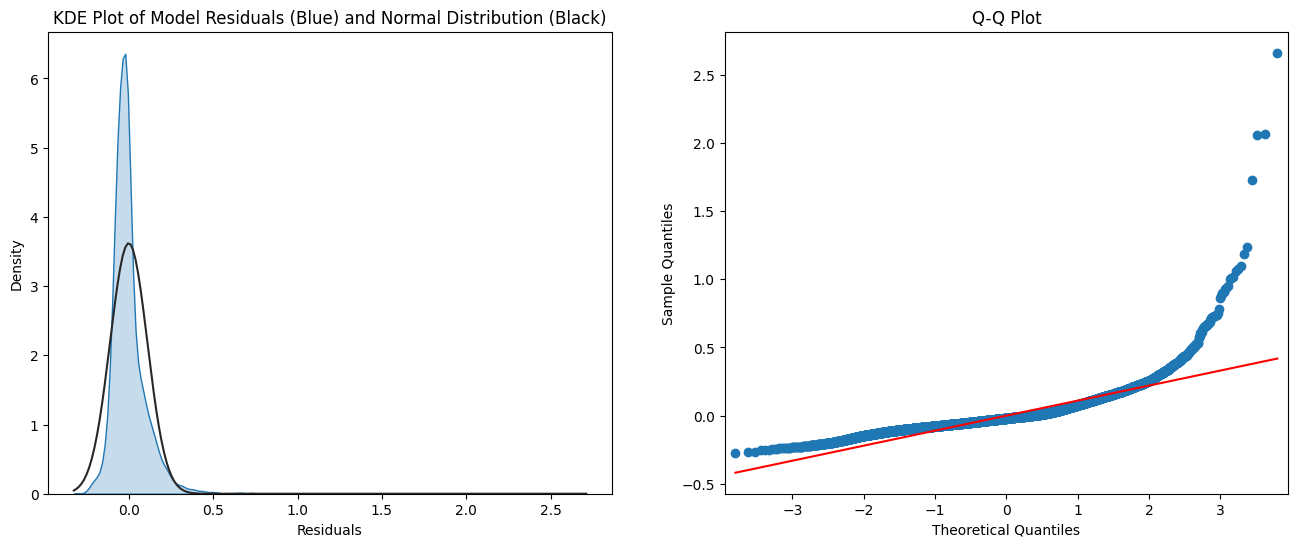

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.distplot(res_lm.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm, ax = ax1)
ax1.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax1.set_xlabel("Residuals")

sm.qqplot(res_lm.resid, dist = stats.norm, line = 's', ax = ax2)
ax2.set_title("Q-Q Plot")

# Null hypothesis rejected = normality of the residuals violated
labels = ["Statistic", "p-value"]
norm_res = stats.shapiro(res_lm.resid)
for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

In [28]:
from statsmodels.stats.diagnostic import het_white

fig = plt.figure(figsize = (16, 9))

ax = sns.boxplot(x = res_lm.model.groups, y = res_lm.resid)

ax.set_title("Distribution of Residuals per STAR")
ax.set_ylabel("Residuals")
ax.set_xlabel("STAR")

# Null hypothesis rejected: homoskedasticity of the variance is violated
het_white_res = het_white(res_lm.resid, res_lm.model.exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)

AttributeError: 'OLS' object has no attribute 'groups'

<Figure size 1600x900 with 0 Axes>